In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output

In [2]:
import copy
import dill
import numpy as np
import pandas as pd
import mat73
import h5py
import scipy
import scipy.io as io
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split


from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import sys
sys.path.append('../../machineLearning/remake/helpers/')
from load_data import load_data_full
# sys.path.append('../helper_functions')
# sys.path.append('../objects')

# sys.path.append('../tools/')
# sys.path.append('../../electrodynamic/helper_functions/')
# sys.path.append('../../electrodynamic/uniform_points_generation/')
# from load_electrodynamic_data import load_OLD_electrodynamic_data, load_data_full
# from general_tools import compute_pp_mod, compute_pn_mod, plot_observation_vs_predictions
# from torch_tools import parse_device, compute_feats, compute_percentage_error
# from NNs_on_LFP_tools import create_simple_model, PairedLfpResponseDset, RCModelTrainer
# from model_trainer import ModelTrainer

import matplotlib

matplotlib.rcParams['xtick.major.size']  = 10
matplotlib.rcParams['xtick.major.width'] = 4
matplotlib.rcParams['xtick.minor.size']  = 5
matplotlib.rcParams['xtick.minor.width'] = 2

matplotlib.rcParams['ytick.major.size']  = 10
matplotlib.rcParams['ytick.major.width'] = 4
matplotlib.rcParams['ytick.minor.size']  = 5
matplotlib.rcParams['ytick.minor.width'] = 2

matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.bottom'] = True

# Analyze EOD variation effects on stimuli

In [15]:
fish_eod_id = 2
sampling_rate = 2.5e6
file_name = f'../../electrodynamic/data/processed/data_231022_SingleFish_EODid{fish_eod_id}_ManyRC'

use_torch = False
find_base_id_for_each_EI=False

[properties_dict,
properties_ids_base, properties_ids_pert,
base_EI, base_LEODs, pert_EI, pert_LEODs,
# aquarium properties
water_conductivities, boundary_normals, boundary_displacements,
# fish properties
tail_lateral_angle, tail_dor_ven_angle, tail_location_percent, fish_yaw, fish_pitch, fish_roll,
# worm properties
resistances, capacitances, worm_radii, worm_xs, worm_ys, worm_zs,
# statistics of receptor responses
receptors_avg, receptors_std,
# objects used in simulations
aqua_objs, fish_objs, worm_objs] = \
    load_data_full(file_name=file_name, use_torch=use_torch, find_base_id_for_each_EI=find_base_id_for_each_EI)
    
print(properties_ids_base.shape)
print(properties_ids_pert.shape)

base_LEODs = base_LEODs[:].squeeze()
pert_LEODs = pert_LEODs[:].squeeze() / base_LEODs.ptp()
base_LEODs = base_LEODs / base_LEODs.ptp()

Data loaded.
(1, 10)
(225, 17)


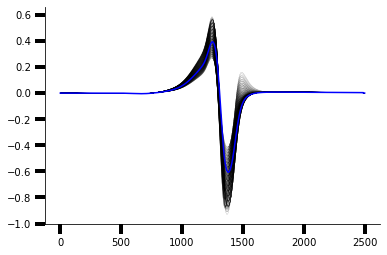

In [16]:
plt.plot(pert_LEODs.T, 'k', lw=0.1)
plt.plot(base_LEODs, 'b')
plt.show()

In [17]:
pca = PCA(n_components=2).fit(pert_LEODs)
pert_feats = pca.transform(pert_LEODs)
base_feats = pca.transform(base_LEODs[np.newaxis])

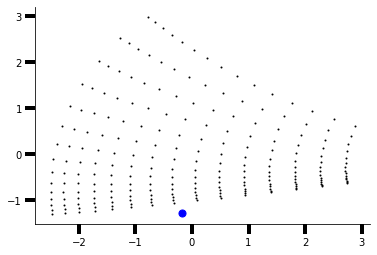

In [18]:
idx  = np.ones(pert_feats.shape[0]).astype(bool)
# idx &= (properties_ids_pert[:,properties_dict['resistances']]  < 80) & (properties_ids_pert[:,properties_dict['resistances']]  > 20) & (properties_ids_pert[:,properties_dict['resistances']]  % 4 == 0)
# idx &= (properties_ids_pert[:,properties_dict['capacitances']] < 45) & (properties_ids_pert[:,properties_dict['capacitances']] > 0 ) & (properties_ids_pert[:,properties_dict['capacitances']] % 3 == 0)

plt.scatter(*pert_feats[idx].T, color='k', s=1)
plt.scatter(*base_feats.T, color='b', s=50)
# plt.xlim([-5, 7])
# plt.ylim([-2, 4])
plt.show()

In [19]:
stim_df = pd.DataFrame()
for i in range(pert_LEODs.shape[0]):
    res = resistances[ properties_ids_pert[:, properties_dict['resistances']][ i]]
    cap = capacitances[properties_ids_pert[:, properties_dict['capacitances']][i]]
    stim_df = pd.concat(
        [stim_df,
         pd.DataFrame.from_dict([dict(
             marker=i+2,
             waveform=pert_LEODs[i],
             maxv=pert_LEODs[i].max(),
             minv=pert_LEODs[i].min(),
             samprate=sampling_rate,
             resistance=res,
             capacitance=cap
         )])],
        ignore_index=True
    )

stim_df = pd.concat(
        [stim_df,
         pd.DataFrame.from_dict([dict(
             marker=1,
             waveform=base_LEODs,
             maxv=base_LEODs.max(),
             minv=base_LEODs.min(),
             samprate=sampling_rate,
             resistance=-1,
             capacitance=-1
         )])],
        ignore_index=True
    )
stim_df = stim_df.to_dict(orient='list')
for k in stim_df:
    stim_df[k] = np.array(stim_df[k])

In [20]:
io.savemat(f'20231024_fishID_{fish_eod_id}.mat', stim_df)